In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [20]:
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go
#data1 = yf.download("AMC", start="2021-05-29", end="2021-06-05", interval="1m")
#data2 = yf.download("AMC", start="2021-05-21", end="2021-05-28", interval="1m")
#data3 = yf.download("AMC", start="2021-05-13", end="2021-05-20", interval="1m")
#data4 = yf.download("AMC", start="2021-05-07", end="2021-05-12", interval="1m")

[*********************100%***********************]  1 of 1 completed


In [21]:
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)


(1529, 6)
(1950, 6)
(1944, 6)
(1170, 6)


In [98]:
data = data4.append(data3.append(data2.append(data1)))

In [99]:
df = pd.DataFrame(data, columns = ['Open','High','Low','Close','Adj Close','Volume'])
# writing data frame to a CSV file
df.to_csv('AMCAdvanced.csv')

In [100]:
df = pd.read_csv('AMCAdvanced.csv')
df['Dates'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M').dt.date
df['Hour'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M').dt.time
df.drop(df.columns[[0]], axis = 1, inplace = True)

In [101]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,Dates,Hour
0,9.3200,9.3200,9.2201,9.2400,9.2400,2030508,2021-05-07,09:30:00
1,9.2337,9.2600,9.1400,9.1719,9.1719,436014,2021-05-07,09:31:00
2,9.1610,9.2600,9.1601,9.2201,9.2201,180066,2021-05-07,09:32:00
3,9.2201,9.2201,9.1600,9.1806,9.1806,243693,2021-05-07,09:33:00
4,9.1858,9.2100,9.1700,9.2098,9.2098,152035,2021-05-07,09:34:00
5,9.2050,9.2700,9.1910,9.2600,9.2600,192454,2021-05-07,09:35:00
6,9.2600,9.4100,9.2500,9.3900,9.3900,519775,2021-05-07,09:36:00
7,9.3900,9.4800,9.3600,9.4000,9.4000,521259,2021-05-07,09:37:00
8,9.4000,9.4300,9.3100,9.3550,9.3550,499970,2021-05-07,09:38:00
9,9.3550,9.4100,9.3400,9.4090,9.4090,247973,2021-05-07,09:39:00


In [45]:
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                         SARIMAX Results                                         
Dep. Variable:                                     Close   No. Observations:                 6593
Model:             SARIMAX(3, 1, 4)x(0, 1, [1, 2, 3], 5)   Log Likelihood               -3529.337
Date:                                   Sun, 06 Jun 2021   AIC                           7080.674
Time:                                           11:07:57   BIC                           7155.396
Sample:                                                0   HQIC                          7106.501
                                                  - 6593                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8588      0.006    132.522      0.000   

In [46]:
best_model.save('bestTimeSeriesModel2')
from statsmodels.tsa.arima.model import ARIMAResults
loadedmodel = ARIMAResults.load('bestTimeSeriesModel2')

In [102]:
print(loadedmodel.predict(start=df.Close.shape[0], end=df.Close.shape[0] + 25))
print(mean_absolute_percentage_error(df.Close[s+d:], loadedmodel.fittedvalues[s+d:]))

6593    47.864765
6594    47.902812
6595    48.011017
6596    48.005391
6597    47.987803
6598    47.973720
6599    48.023517
6600    48.001796
6601    48.072177
6602    48.113064
6603    48.173329
6604    48.165942
6605    48.202055
6606    48.170189
6607    48.199081
6608    48.173603
6609    48.181835
6610    48.152596
6611    48.145343
6612    48.128985
6613    48.139298
6614    48.120781
6615    48.135565
6616    48.114403
6617    48.144368
6618    48.146359
Name: predicted_mean, dtype: float64
0.47926342138311756


In [103]:
comparison = pd.DataFrame({'predicted': loadedmodel.predict(start=df.Close.shape[0]-25, end=df.Close.shape[0]-1), 'actual': df.tail(25)['Close']})

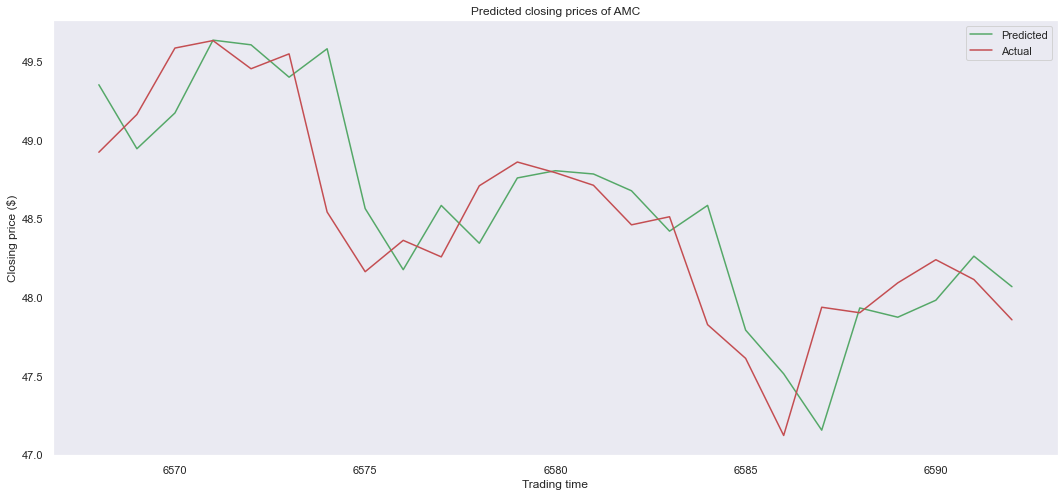

In [104]:
plt.figure(figsize=(18, 8))
plt.plot(comparison.predicted,'g', label='Predicted')
plt.plot(comparison.actual,'r',label='Actual')
plt.title('Predicted closing prices of AMC')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading time')
plt.legend(loc='best')
plt.grid(False)
plt.show()

In [105]:
df_list = [d for _, d in df.groupby(['Dates'])]
print(df_list[1])

       Open     High      Low    Close  Adj Close   Volume       Dates  \
390   9.990   9.9900   9.9400   9.9850     9.9850  3456580  2021-05-10   
391   9.980  10.0500   9.9607  10.0200    10.0200   696309  2021-05-10   
392  10.020  10.0700   9.9900  10.0499    10.0499   472174  2021-05-10   
393  10.045  10.1500  10.0200  10.1292    10.1292   626116  2021-05-10   
394  10.130  10.1500  10.0200  10.0400    10.0400   473093  2021-05-10   
..      ...      ...      ...      ...        ...      ...         ...   
775   9.750   9.7600   9.7400   9.7550     9.7550    99206  2021-05-10   
776   9.750   9.7578   9.7200   9.7313     9.7313   113643  2021-05-10   
777   9.740   9.7500   9.7300   9.7450     9.7450   126815  2021-05-10   
778   9.745   9.7500   9.7313   9.7450     9.7450   138064  2021-05-10   
779   9.745   9.7500   9.7300   9.7400     9.7400   272321  2021-05-10   

         Hour  
390  09:30:00  
391  09:31:00  
392  09:32:00  
393  09:33:00  
394  09:34:00  
..        ...  

In [106]:
print(temp.index[1])

1


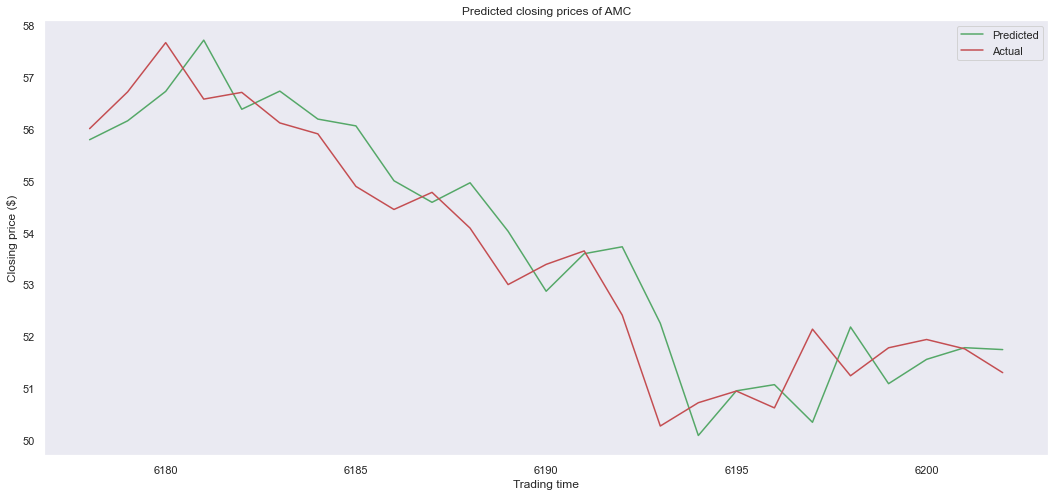

In [112]:
temp = df_list[15]
comparison = pd.DataFrame({'predicted': loadedmodel.predict(start=temp.last_valid_index()-24, end=temp.last_valid_index()), 'actual': temp.tail(25)['Close']})
plt.figure(figsize=(18, 8))
plt.plot(comparison.predicted,'g', label='Predicted')
plt.plot(comparison.actual,'r',label='Actual')
plt.title('Predicted closing prices of AMC')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading time')
plt.legend(loc='best')
plt.grid(False)
plt.show()